In [1]:
from nbed.driver import NbedDriver
from nbed.ham_builder import HamiltonianBuilder
from openfermion import get_sparse_operator
import scipy as sp
from openfermion.utils import count_qubits
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from nbed.mol_plot import Draw_molecule

/home/lex/anaconda3/envs/embed/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
current_dir = os.getcwd()
structure_dir =  os.path.join(current_dir, "molecular_structures")

In [3]:
filename = 'H4_beta_90_bottom_top_bottom_top_order.xyz'
xyz_file_loc = os.path.join(structure_dir, filename)        

In [4]:
with open(xyz_file_loc, 'r') as infile:
    xyz = infile.read()

mol_viewer = Draw_molecule(xyz)
mol_viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [5]:
basis = 'STO-3G'#'3-21G' #'STO-3G'
xc_functional = 'B3LYP'
convergence = 1e-6
charge = 0
mu_level_shift=1e6
run_ccsd_emb = False
run_fci_emb = True
max_ram_memory = 8_000
pyscf_print_level = 1
unit = 'angstrom'

occupied_threshold = 0.95
virtual_threshold = 0.95

max_hf_cycles=10_000
max_dft_cycles = 10_000

transform = 'jordan_wigner'

In [6]:
# n_active_atoms = 1
localization = 'ibo' #spade, ibo

projector = 'both' #'both', 'huzinaga', 'mu'
init_huzinaga_rhf_with_mu = False

In [7]:
def get_hamiltonian_from_driver(rhf_pyscf, energy_shift, qubit_transform):
    # n_qubits = 2*rhf_pyscf.mol.nao
    qham = HamiltonianBuilder(
                            scf_method=rhf_pyscf,
                            constant_e_shift=energy_shift,
                            transform=qubit_transform,
                            ).build(n_qubits=None, taper=False)
    return qham

In [8]:
global_dft_list=[]
global_fci_list=[]
global_H_diag_list=[]
global_qubit_H_length_list=[]
global_qubit_H_nqubits=[]

huz_rhf_list=[]
# huz_ccsd_list=[]
huz_fci_list=[]
huz_H_diag_list=[]
huz_qubit_H_length_list=[]
huz_H_nqubits=[]

mu_rhf_list=[]
# mu_ccsd_list=[]
mu_fci_list=[]
mu_H_diag_list=[]
mu_qubit_H_length_list=[]
mu_H_nqubits=[]
N_active_AOs = []

for n_active in tqdm(range(1,4)):
    driver = NbedDriver(
            geometry=xyz_file_loc, # <-- fixed
            n_active_atoms=n_active, # <-- changing!
            basis=basis,
            xc_functional=xc_functional,
            projector=projector,
            localization=localization,
            convergence=convergence,
            charge=charge,
            mu_level_shift=mu_level_shift,
            run_ccsd_emb=run_ccsd_emb,
            run_fci_emb=run_fci_emb,
            max_ram_memory=max_ram_memory,
            pyscf_print_level=pyscf_print_level,
            unit=unit,
            occupied_threshold=occupied_threshold,
            virtual_threshold=virtual_threshold,
            max_hf_cycles=max_hf_cycles,
            max_dft_cycles=max_dft_cycles,
            _init_huzinaga_rhf_with_mu = init_huzinaga_rhf_with_mu)

    
    print('***')
    print(driver.localized_system.active_MO_inds)
    print(driver.localized_system.enviro_selection_condition)
    print(driver._global_rks.e_tot)
    print('***')
    print()
    
    ## global
    global_dft_list.append(driver._global_rks.e_tot)
    global_fci_list.append(driver._global_fci.e_tot)
    
    global_qubit_Ham = get_hamiltonian_from_driver(driver._global_hf,
                                           driver._global_hf.energy_nuc(), 
                                           transform)
    
    global_H_sparse = get_sparse_operator(global_qubit_Ham)
    E_fci =  sp.sparse.linalg.eigsh(global_H_sparse, k=1, which='SA')[0][0] 
    global_H_diag_list.append(E_fci)

    global_qubit_H_length_list.append(len(global_qubit_Ham.terms))
    global_qubit_H_nqubits.append(count_qubits(global_qubit_Ham))

    ##
    N_active_AOs.append(len(driver.localized_system.active_MO_inds))
    
    # HUZ
    huz_rhf_list.append(driver._huzinaga['e_rhf'])
#     huz_ccsd_list.append(driver._huzinaga['e_ccsd'])
    huz_fci_list.append(driver._huzinaga['e_fci'])

    huz_classical = driver._huzinaga['classical_energy']
    huz_qubit_Ham = get_hamiltonian_from_driver(driver._huzinaga["scf"],
                                        huz_classical, #+ driver._huzinaga["scf"].energy_nuc(), 
                                        transform)
    
    huz_H_sparse = get_sparse_operator(huz_qubit_Ham)
    huz_e_emb = sp.sparse.linalg.eigsh(huz_H_sparse, k=1, which='SA')[0][0]
    huz_H_diag_list.append(huz_e_emb)

    huz_qubit_H_length_list.append(len(huz_qubit_Ham.terms))
    huz_nqubits = count_qubits(huz_qubit_Ham)
    huz_H_nqubits.append(huz_nqubits)

    # mu shift
    mu_rhf_list.append(driver._mu['e_rhf'])
#     mu_ccsd_list.append(driver._mu['e_ccsd'])
    mu_fci_list.append(driver._mu['e_fci'])
    
    mu_classical = driver._mu['classical_energy']
    mu_qubit_Ham = get_hamiltonian_from_driver(driver._mu["scf"],
                                        mu_classical, #+ driver._mu["scf"].energy_nuc(), 
                                        transform)
    
    mu_H_sparse = get_sparse_operator(mu_qubit_Ham)
    mu_e_emb = sp.sparse.linalg.eigsh(mu_H_sparse, k=1, which='SA')[0][0]
    mu_H_diag_list.append(mu_e_emb)
    
    mu_nqubits = count_qubits(huz_qubit_Ham)
    mu_qubit_H_length_list.append(len(mu_qubit_Ham.terms))
    mu_H_nqubits.append(mu_nqubits)
    
    del driver



  0%|          | 0/3 [00:00<?, ?it/s]

 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 2.57e-09


active system %: 0.4994282247496591 

***
[0]
[4.99428225e-01 4.10404938e-04]
-1.692360936881828
***

 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 1.65e-16


active system %: 0.5000000283791667 

***
[0]
[0.50000003 0.49999998]
-1.6923609861407911
***

 Iterative localization: IB/P4/2x2, 1 iter; Final gradient 7.09e-11
***
[0]
[0.99959624 0.50092416]
-1.6923603005355665
***



In [9]:
import pandas as pd
exp_data = {
    'global DFT': global_dft_list, 
    
    'global FCI': global_fci_list,
    'huz emb FCI': huz_H_diag_list,
    'mu emb FCI': mu_H_diag_list,
    
    'global H': global_qubit_H_length_list,
    'huz H emb': huz_qubit_H_length_list,
    'mu H emb': mu_qubit_H_length_list,
    
    'global n qubits ': global_qubit_H_nqubits,
    'huz n qubits ': huz_H_nqubits,
    'mu n qubits ': mu_H_nqubits,
    'N active AOs ': N_active_AOs,
    
}

df = pd.DataFrame(data=exp_data)

df

,global DFT,global FCI,huz emb FCI,mu emb FCI,global H,huz H emb,mu H emb,global n qubits,huz n qubits,mu n qubits,N active AOs
0,-1.692361,-1.874311,-1.782202,-1.782202,105,118,118,8,6,6,1
1,-1.692361,-1.874311,-1.782223,-1.782223,105,70,62,8,6,6,1
2,-1.692360,-1.874311,-1.782226,-1.782226,105,118,118,8,6,6,1


In [ ]:
# note this goes from 1 active to 3 active (not 0-2!)

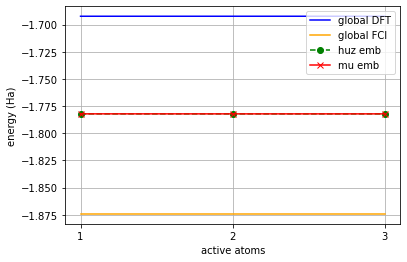

In [11]:
%matplotlib inline

act_atoms = list(range(1,4))

plt.plot(act_atoms, global_dft_list, label='global DFT', color='b')
plt.plot(act_atoms, global_fci_list, label='global FCI', color='orange')
plt.plot(act_atoms, huz_H_diag_list, label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(act_atoms, mu_H_diag_list, label='mu emb', linestyle='-', marker='x', color='r')

plt.xlabel('active atoms')
plt.ylabel('energy (Ha)')

plt.xticks(act_atoms)

plt.grid(True)
# plt.savefig("test.png")
plt.legend()
plt.show()

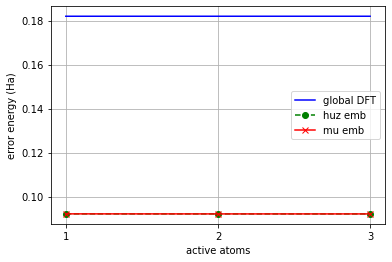

In [13]:
%matplotlib inline

act_atoms = list(range(1,4))

plt.plot(act_atoms, np.array(global_dft_list) - np.array(global_fci_list), label='global DFT', color='b')
plt.plot(act_atoms, np.array(huz_H_diag_list) - np.array(global_fci_list), label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(act_atoms, np.array(mu_H_diag_list) - np.array(global_fci_list), label='mu emb', linestyle='-', marker='x', color='r')

plt.xlabel('active atoms')
plt.ylabel('error energy (Ha)')

plt.xticks(act_atoms)

plt.grid(True)
# plt.savefig("test.png")
plt.legend()
plt.show()